# Fruit project


In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from PIL import Image

# Dataset directories
base_dir = r"C:\Users\Baki Akgun\OneDrive\Masaüstü\Fruit\fruits-360_dataset_100x100"
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Helper function to load data using PIL
def load_data_pil(data_dir, img_size=(100, 100)):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(img_size)
            images.append(np.array(img))
            labels.append(class_name)
    return np.array(images), np.array(labels), class_names


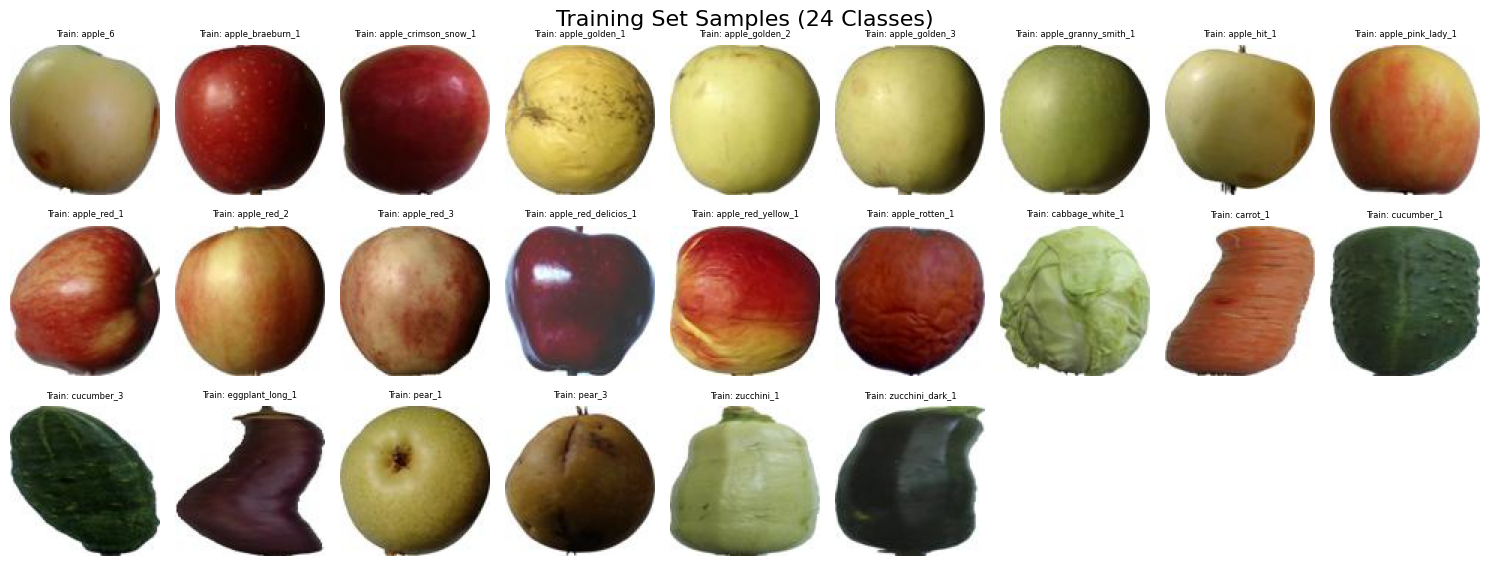

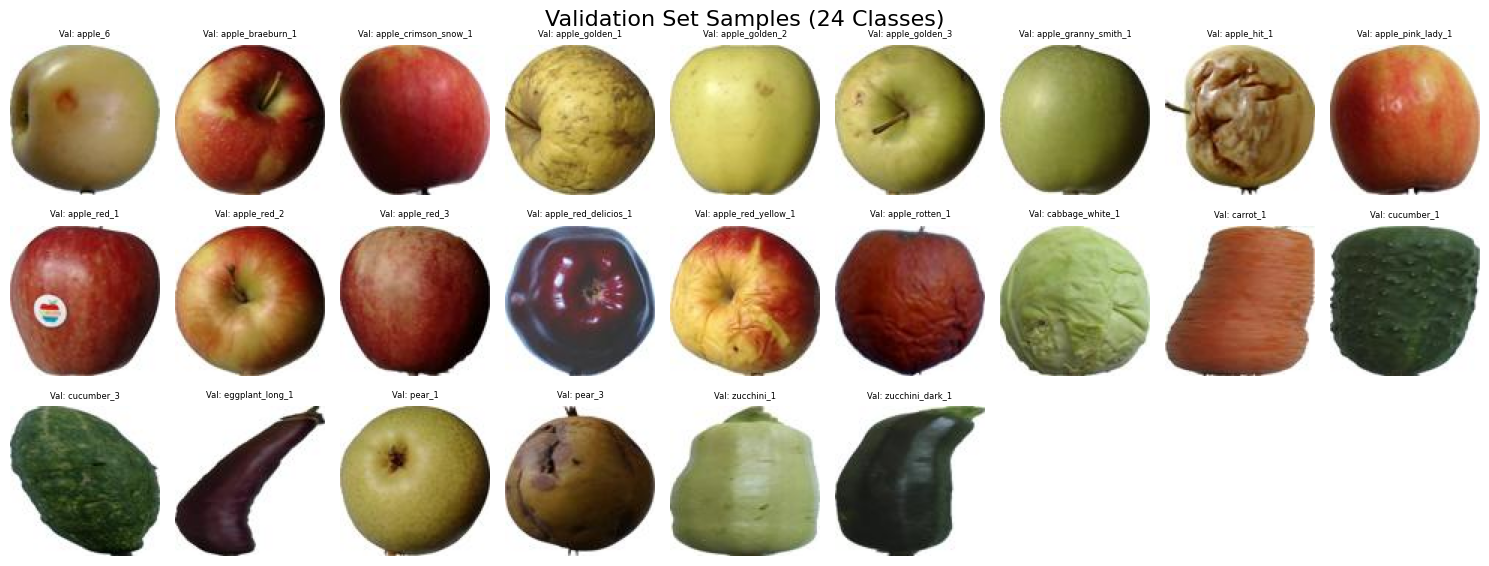

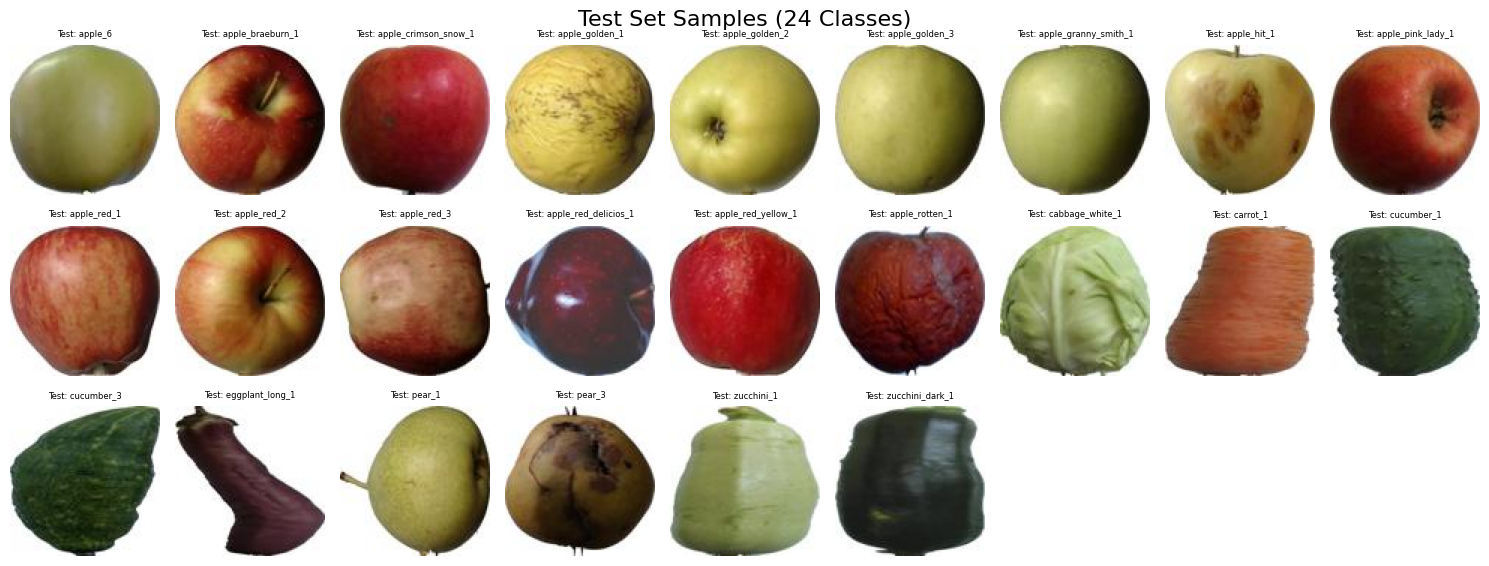

In [2]:
# Her veri seti klasöründen 24 farklı sınıfın birer örneğini alacak fonksiyon
def get_one_sample_per_class(data_dir, img_size=(100, 100)):
    sample_images = []
    sample_labels = []
    class_names = os.listdir(data_dir)[:24]  # İlk 24 sınıfı al (24 sınıf mevcut olduğunu varsayıyoruz)
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        img_file = random.choice(os.listdir(class_path))  # Her sınıftan rastgele bir örnek seç
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).resize(img_size)
        sample_images.append(np.array(img))
        sample_labels.append(class_name)
    return sample_images, sample_labels

# Training, Validation ve Test klasörlerinden örnekleri al
train_samples, train_labels = get_one_sample_per_class(train_dir, img_size=(100, 100))
val_samples, val_labels = get_one_sample_per_class(val_dir, img_size=(100, 100))
test_samples, test_labels = get_one_sample_per_class(test_dir, img_size=(100, 100))

# Show sample images
plt.figure(figsize=(15, 15))

# Training samples
for i, (img, label) in enumerate(zip(train_samples, train_labels)):
    plt.subplot(8, 9, i + 1)  # 8x9'luk bir grid kullanarak görselleri yerleştir
    plt.imshow(img)
    plt.title(f"Train: {label}", fontsize=6)
    plt.axis('off')

plt.suptitle("Training Set Samples (24 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Validation samples
plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(zip(val_samples, val_labels)):
    plt.subplot(8, 9, i + 1)
    plt.imshow(img)
    plt.title(f"Val: {label}", fontsize=6)
    plt.axis('off')

plt.suptitle("Validation Set Samples (24 Classes)", fontsize=16)
plt.tight_layout()
plt.show()

# Test samples
plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(zip(test_samples, test_labels)):
    plt.subplot(8, 9, i + 1)
    plt.imshow(img)
    plt.title(f"Test: {label}", fontsize=6)
    plt.axis('off')

plt.suptitle("Test Set Samples (24 Classes)", fontsize=16)
plt.tight_layout()
plt.show()


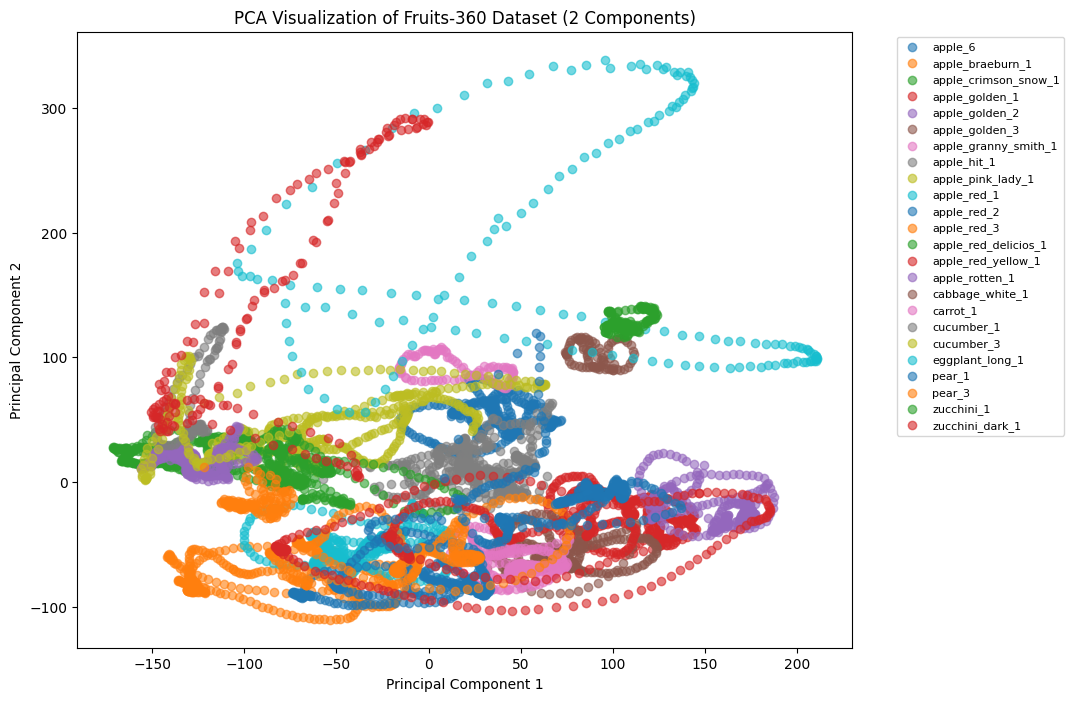

In [3]:
# Load data from all directories (Train, Validation, Test)
train_images_pil, train_labels_pil, class_names_pil = load_data_pil(train_dir, img_size=(100, 100))
val_images_pil, val_labels_pil, _ = load_data_pil(val_dir, img_size=(100, 100))
test_images_pil, test_labels_pil, _ = load_data_pil(test_dir, img_size=(100, 100))

# Flatten the images into 1D vectors
train_images_flat = train_images_pil.reshape(train_images_pil.shape[0], -1)
val_images_flat = val_images_pil.reshape(val_images_pil.shape[0], -1)
test_images_flat = test_images_pil.reshape(test_images_pil.shape[0], -1)

# Normalize the data
scaler = StandardScaler()
train_images_normalized = scaler.fit_transform(train_images_flat)
val_images_normalized = scaler.transform(val_images_flat)
test_images_normalized = scaler.transform(test_images_flat)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
train_images_pca = pca.fit_transform(train_images_normalized)
val_images_pca = pca.transform(val_images_normalized)
test_images_pca = pca.transform(test_images_normalized)

# Visualize the PCA results
plt.figure(figsize=(10, 8))
for i, label in enumerate(np.unique(train_labels_pil)):
    plt.scatter(train_images_pca[train_labels_pil == label, 0],
                train_images_pca[train_labels_pil == label, 1], label=label, alpha=0.6)

plt.title("PCA Visualization of Fruits-360 Dataset (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()

# Convert labels to numeric values (for sklearn models)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels_pil)
y_val_encoded = label_encoder.transform(val_labels_pil)
y_test_encoded = label_encoder.transform(test_labels_pil)


In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Veri artırma (Data Augmentation) ve hazırlama
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalizasyon ve bölme

# Eğitim ve doğrulama veri setleri
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Modellerin tanımlanması ve sıfırdan eğitilmesi
def create_model(base_model, num_classes):
    """
    Sıfırdan eğitim için temel modele üst katmanlar eklenir.
    """
    base_model.trainable = True  # Fine-tuning için katmanlar eğitilebilir
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Modelleri oluştur
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(100, 100, 3))
resnet50_base = ResNet50(weights=None, include_top=False, input_shape=(100, 100, 3))
inceptionv3_base = InceptionV3(weights=None, include_top=False, input_shape=(100, 100, 3))

vgg16_model = create_model(vgg16_base, num_classes=len(train_generator.class_indices))
resnet50_model = create_model(resnet50_base, num_classes=len(train_generator.class_indices))
inceptionv3_model = create_model(inceptionv3_base, num_classes=len(train_generator.class_indices))

# Eğitim fonksiyonu
def train_model(model, train_data, val_data, epochs=10):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    return history

# VGG16 Model Eğitimi
print("Training VGG16...")
vgg16_history = train_model(vgg16_model, train_generator, val_generator, epochs=10)

# ResNet50 Model Eğitimi
print("Training ResNet50...")
resnet50_history = train_model(resnet50_model, train_generator, val_generator, epochs=10)

# InceptionV3 Model Eğitimi
print("Training InceptionV3...")
inceptionv3_history = train_model(inceptionv3_model, train_generator, val_generator, epochs=10)

# Eğitim Sonuçlarının Görselleştirilmesi
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(vgg16_history, "VGG16")
plot_training_history(resnet50_history, "ResNet50")
plot_training_history(inceptionv3_history, "InceptionV3")

# Modellerin Kaydedilmesi
vgg16_model.save("vgg16_fruits360.h5")
resnet50_model.save("resnet50_fruits360.h5")
inceptionv3_model.save("inceptionv3_fruits360.h5")

print("Model training and saving completed!")


## Non-Fine Tuning

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 181s 921ms/step - accuracy: 0.1523 - loss: 2.9334 - val_accuracy: 0.4171 - val_loss: 2.1449
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 182s 937ms/step - accuracy: 0.4830 - loss: 1.9989 - val_accuracy: 0.6076 - val_loss: 1.4499
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 186s 955ms/step - accuracy: 0.6435 - loss: 1.3895 - val_accuracy: 0.5951 - val_loss: 1.2101
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 173s 888ms/step - accuracy: 0.7301 - loss: 1.0276 - val_accuracy: 0.7579 - val_loss: 0.9248
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 187s 958ms/step - accuracy: 0.7769 - loss: 0.8473 - val_accuracy: 0.7482 - val_loss: 0.7898
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 156s 801ms/step - accuracy: 0.8092 - loss: 0.7143 - val_accuracy: 0.7954 - val_loss: 0.6636
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 155s 796ms/step - accuracy: 0.8140 - loss: 0.6358 - val_accuracy: 0.8372 - val_los

c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step


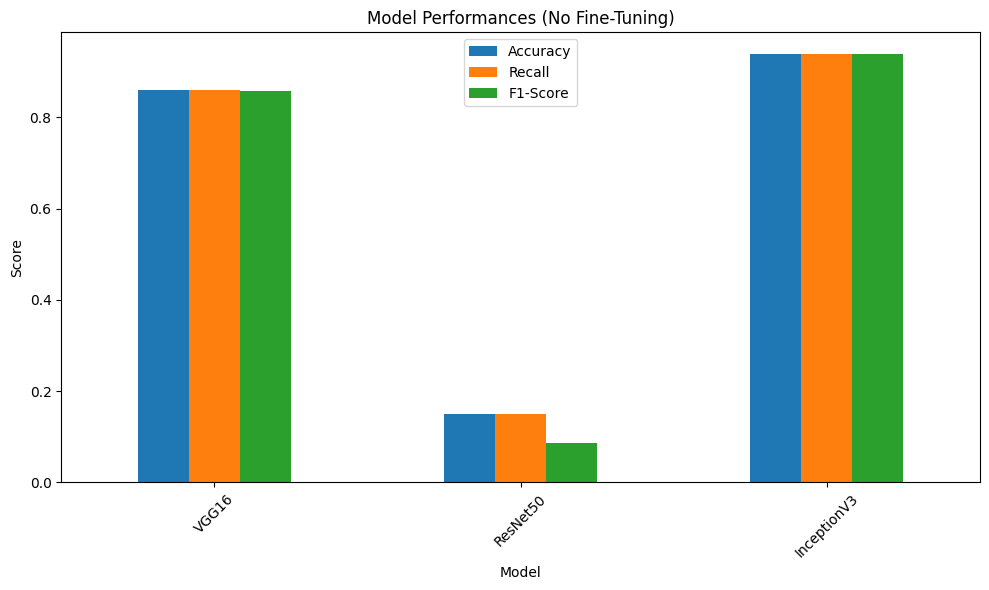

Model  Accuracy    Recall  F1-Score
0        VGG16  0.859345  0.859345  0.857538
1     ResNet50  0.150289  0.150289  0.085506
2  InceptionV3  0.938985  0.938985  0.939228

In [8]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pre-trained modellerin yüklenmesi (fine-tuning yapılmadan, sadece "feature extraction")
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Modelleri dondur (fine-tuning olmadan transfer öğrenimi için)
vgg16_model.trainable = False
resnet50_model.trainable = False
inceptionv3_model.trainable = False

# Özel sınıflandırıcı başlığı ekleyen fonksiyon
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(24, activation='softmax')(x)  # 24 sınıf
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Modellerin oluşturulması
vgg16_model_final = build_model(vgg16_model)
resnet50_model_final = build_model(resnet50_model)
inceptionv3_model_final = build_model(inceptionv3_model)

# Modellerin derlenmesi
for model in [vgg16_model_final, resnet50_model_final, inceptionv3_model_final]:
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Veri artırma (augmentation) ve yeniden ölçeklendirme (rescale)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train ve validation generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # Ensure order consistency for validation
)

# Eğitim süreçleri
history_vgg16 = vgg16_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

history_resnet50 = resnet50_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

history_inceptionv3 = inceptionv3_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Değerlendirme ve metrik hesaplamaları
models = {
    'VGG16': vgg16_model_final,
    'ResNet50': resnet50_model_final,
    'InceptionV3': inceptionv3_model_final
}

results = []
for model_name, model in models.items():
    preds = np.argmax(model.predict(validation_generator), axis=1)
    accuracy = accuracy_score(validation_generator.classes, preds)
    recall = recall_score(validation_generator.classes, preds, average='weighted')
    f1 = f1_score(validation_generator.classes, preds, average='weighted')
    
    # Sınıflandırma raporu ve metrikler
    report = classification_report(validation_generator.classes, preds, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"{model_name}_classification_report_no_fine_tuning.csv")
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1-Score': f1
    })

# Sonuçları tabloya dönüştür ve ekrana yazdır
results_df = pd.DataFrame(results)
results_df

# Metriklerin görselleştirilmesi
results_df.set_index('Model')[['Accuracy', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performances (No Fine-Tuning)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df


## Fine Tuning

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


c:\Users\Baki Akgun\New Folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 192s 970ms/step - accuracy: 0.4241 - loss: 1.9194 - val_accuracy: 0.8838 - val_loss: 0.3273
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 185s 948ms/step - accuracy: 0.9101 - loss: 0.2711 - val_accuracy: 0.9721 - val_loss: 0.0850
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 179s 919ms/step - accuracy: 0.9531 - loss: 0.1339 - val_accuracy: 0.9839 - val_loss: 0.0496
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 185s 950ms/step - accuracy: 0.9706 - loss: 0.0899 - val_accuracy: 0.9952 - val_loss: 0.0215
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 185s 950ms/step - accuracy: 0.9739 - loss: 0.0707 - val_accuracy: 0.9942 - val_loss: 0.0226
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9770 - loss: 0.0698 - val_accuracy: 0.9926 - val_loss: 0.0278
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 186s 955ms/step - accuracy: 0.9849 - loss: 0.0437 - val_accuracy: 0.9958 - val_loss: 0.0105
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 183s 941ms/step - accuracy: 0.9775 - lo

c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step


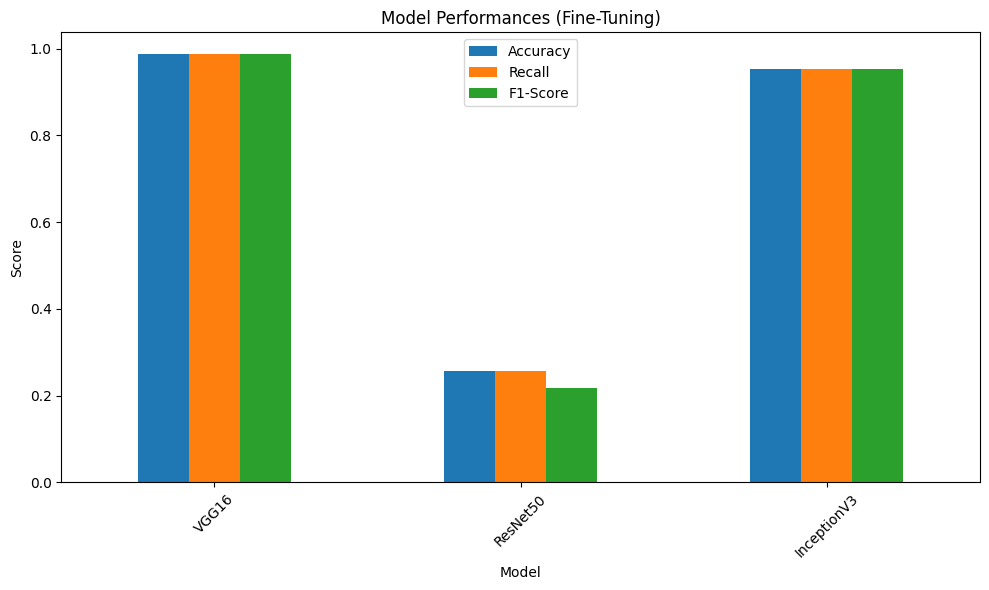

Model  Accuracy    Recall  F1-Score
0        VGG16  0.988118  0.988118  0.987813
1     ResNet50  0.256904  0.256904  0.217405
2  InceptionV3  0.952794  0.952794  0.952788

In [18]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pre-trained modellerin yüklenmesi (fine-tuning yapılacak)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Fine-tuning yapılacak katmanlar için 'trainable' parametresi ayarları
def freeze_base_model(base_model, unfreeze_from_layer=4):
    base_model.trainable = True
    for layer in base_model.layers[:-unfreeze_from_layer]:
        layer.trainable = False

freeze_base_model(vgg16_model, unfreeze_from_layer=4)
freeze_base_model(resnet50_model, unfreeze_from_layer=4)
freeze_base_model(inceptionv3_model, unfreeze_from_layer=4)

# Özel sınıflandırıcı başlığı ekleyen fonksiyon
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(24, activation='softmax')(x)  # 24 sınıf
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Modellerin oluşturulması
vgg16_model_final = build_model(vgg16_model)
resnet50_model_final = build_model(resnet50_model)
inceptionv3_model_final = build_model(inceptionv3_model)

# Modellerin derlenmesi
for model in [vgg16_model_final, resnet50_model_final, inceptionv3_model_final]:
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Veri artırma (augmentation) ve yeniden ölçeklendirme (rescale)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train ve validation generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # Ensure order consistency for validation
)

# Eğitim süreçleri
history_vgg16 = vgg16_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

history_resnet50 = resnet50_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

history_inceptionv3 = inceptionv3_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Değerlendirme ve metrik hesaplamaları
models = {
    'VGG16': vgg16_model_final,
    'ResNet50': resnet50_model_final,
    'InceptionV3': inceptionv3_model_final
}

results = []
for model_name, model in models.items():
    preds = np.argmax(model.predict(validation_generator), axis=1)
    accuracy = accuracy_score(validation_generator.classes, preds)
    recall = recall_score(validation_generator.classes, preds, average='weighted')
    f1 = f1_score(validation_generator.classes, preds, average='weighted')
    
    # Sınıflandırma raporu ve metrikler
    report = classification_report(validation_generator.classes, preds, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"{model_name}_classification_report_fine_tuning.csv")
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1-Score': f1
    })

# Sonuçları tabloya dönüştür ve ekrana yazdır
results_df = pd.DataFrame(results)
results_df

# Metriklerin görselleştirilmesi
results_df.set_index('Model')[['Accuracy', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performances (Fine-Tuning)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df


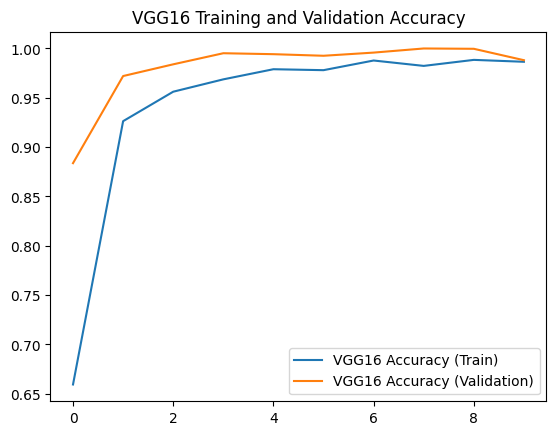

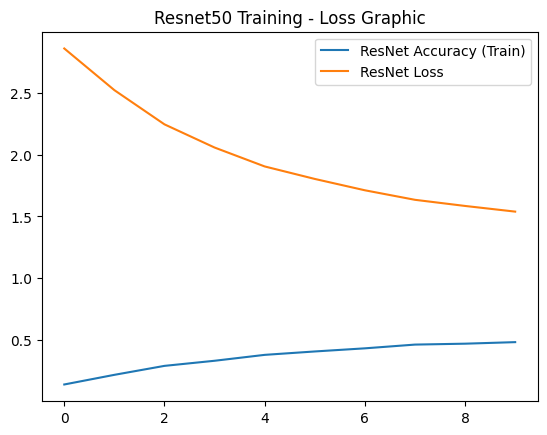

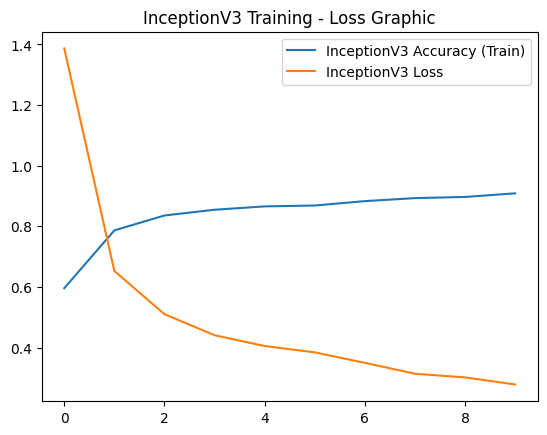

In [19]:
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Accuracy (Train)')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Accuracy (Validation)')
plt.legend()
plt.title('VGG16 Training and Validation Accuracy')
plt.show()

plt.plot(history_resnet50.history['accuracy'], label='ResNet Accuracy (Train)')
plt.plot(history_resnet50.history['loss'], label = 'ResNet Loss')
plt.legend()
plt.title('Resnet50 Training - Loss Graphic')
plt.show()

plt.plot(history_inceptionv3.history['accuracy'], label='InceptionV3 Accuracy (Train)')
plt.plot(history_inceptionv3.history['loss'], label = 'InceptionV3 Loss')
plt.legend()
plt.title('InceptionV3 Training - Loss Graphic')
plt.show()

## Grad-CAM Methods

In [31]:
pip install tf-explain


Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install tf-keras-vis


Note: you may need to restart the kernel to use updated packages.


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 588ms/step


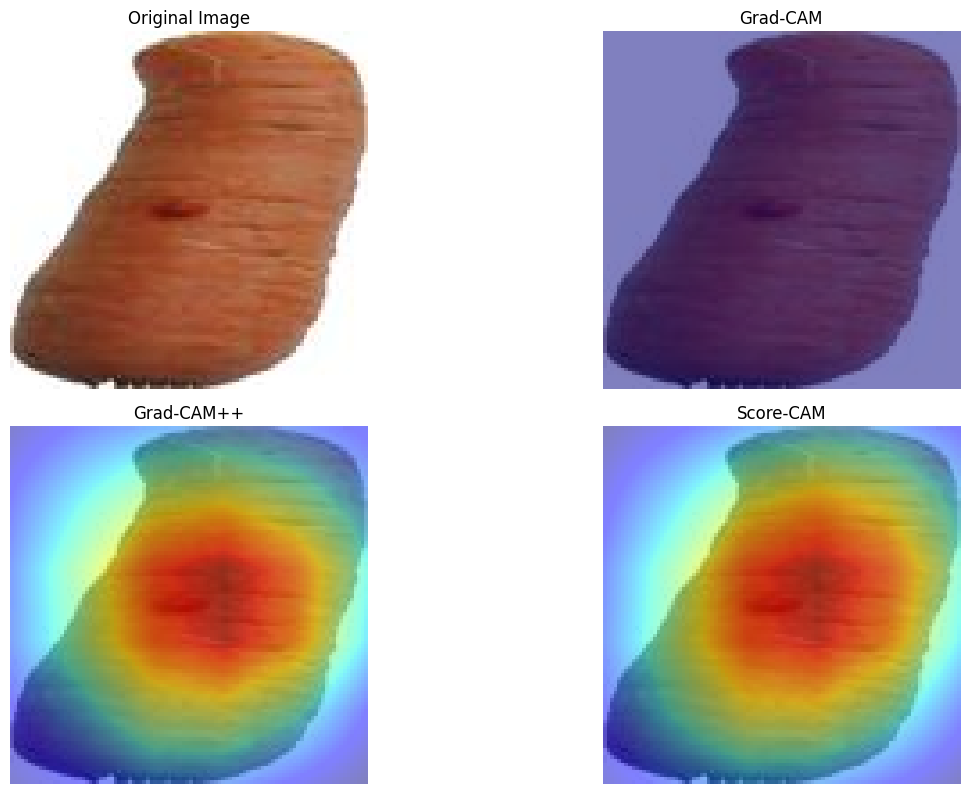

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step


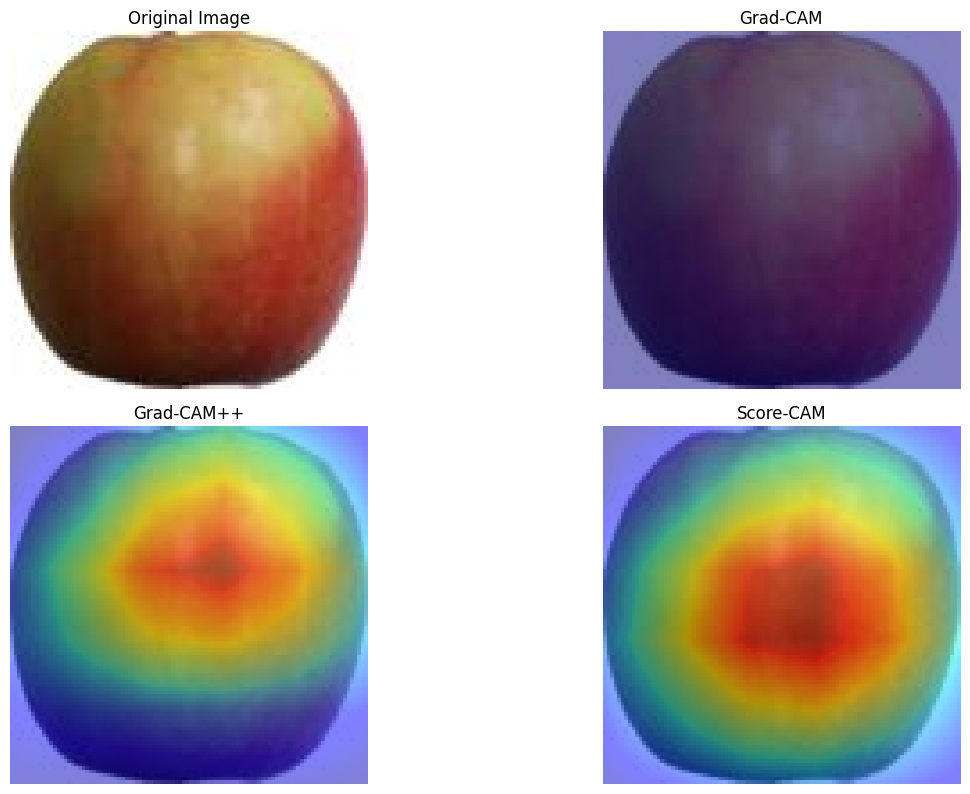

In [62]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam as GradcamClass
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.scorecam import ScoreCAM  # For Score-CAM

# Görüntüyü yüklemek ve ön işlemek için fonksiyon
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(100, 100))  # Modelin giriş boyutuna göre yeniden boyutlandırma
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizasyon
    return img, img_array

# Grad-CAM, Grad-CAM++, Score-CAM ve XGrad-CAM görselleştirmesi için fonksiyon
def cam_methods(model, image_path, class_idx):
    img, img_array = load_and_preprocess_image(image_path)

    # Grad-CAM
    grad_cam = GradcamClass(model)
    grad_cam_map = grad_cam(CategoricalScore(class_idx), img_array)

    # Grad-CAM++
    grad_cam_plus_plus = GradcamPlusPlus(model)
    grad_cam_plus_plus_map = grad_cam_plus_plus(CategoricalScore(class_idx), img_array)

    # Score-CAM
    score_cam = ScoreCAM(model)
    score_cam_map = score_cam(CategoricalScore(class_idx), img_array)


    # Sonuçları Görselleştirme
    plt.figure(figsize=(12, 12))

    # Orijinal Görüntü
    plt.subplot(3, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Grad-CAM
    plt.subplot(3, 2, 2)
    plt.imshow(img)
    plt.imshow(grad_cam_map[0], cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')

    # Grad-CAM++
    plt.subplot(3, 2, 3)
    plt.imshow(img)
    plt.imshow(grad_cam_plus_plus_map[0], cmap='jet', alpha=0.5)
    plt.title("Grad-CAM++")
    plt.axis('off')

    # Score-CAM
    plt.subplot(3, 2, 4)
    plt.imshow(img)
    plt.imshow(score_cam_map[0], cmap='jet', alpha=0.5)
    plt.title("Score-CAM")
    plt.axis('off')



    plt.tight_layout()
    plt.show()

# Modeli yükleme ve fonksiyonu çağırma
image_path = "C:/Users/Baki Akgun/OneDrive/Masaüstü/Fruit/fruits-360_dataset_100x100/Test/carrot_1/r0_19.jpg"
image_path1 = "C:/Users/Baki Akgun/OneDrive/Masaüstü/Fruit/fruits-360_dataset_100x100/Test/apple_pink_lady_1/r0_11.jpg"

class_idx = 0  # Hedef sınıfın indeksini modelinize uygun ayarlayın

# Fonksiyonu çağırma
cam_methods(vgg16_model_final, image_path, class_idx)
cam_methods(vgg16_model_final, image_path1, class_idx)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Epoch 1/10


c:\Users\Baki Akgun\New Folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 587ms/step - accuracy: 0.1098 - loss: 2.9941 - val_accuracy: 0.1875 - val_loss: 2.7457
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 535ms/step - accuracy: 0.2152 - loss: 2.5451 - val_accuracy: 0.2052 - val_loss: 2.4970
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 551ms/step - accuracy: 0.2570 - loss: 2.3030 - val_accuracy: 0.1753 - val_loss: 2.4675
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 533ms/step - accuracy: 0.3149 - loss: 2.1216 - val_accuracy: 0.3475 - val_loss: 1.8266
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 540ms/step - accuracy: 0.3677 - loss: 1.9267 - val_accuracy: 0.2174 - val_loss: 2.4667
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 583ms/step - accuracy: 0.3863 - loss: 1.8411 - val_accuracy: 0.2486 - val_loss: 2.3364
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 560ms/step - accuracy: 0.4219 - loss: 1.7443 - val_accuracy: 0.3754 - val_loss: 1.8687
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 117s 599ms/step - accuracy: 0.4495 - loss: 1.64

c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Baki Akgun\New Folder\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


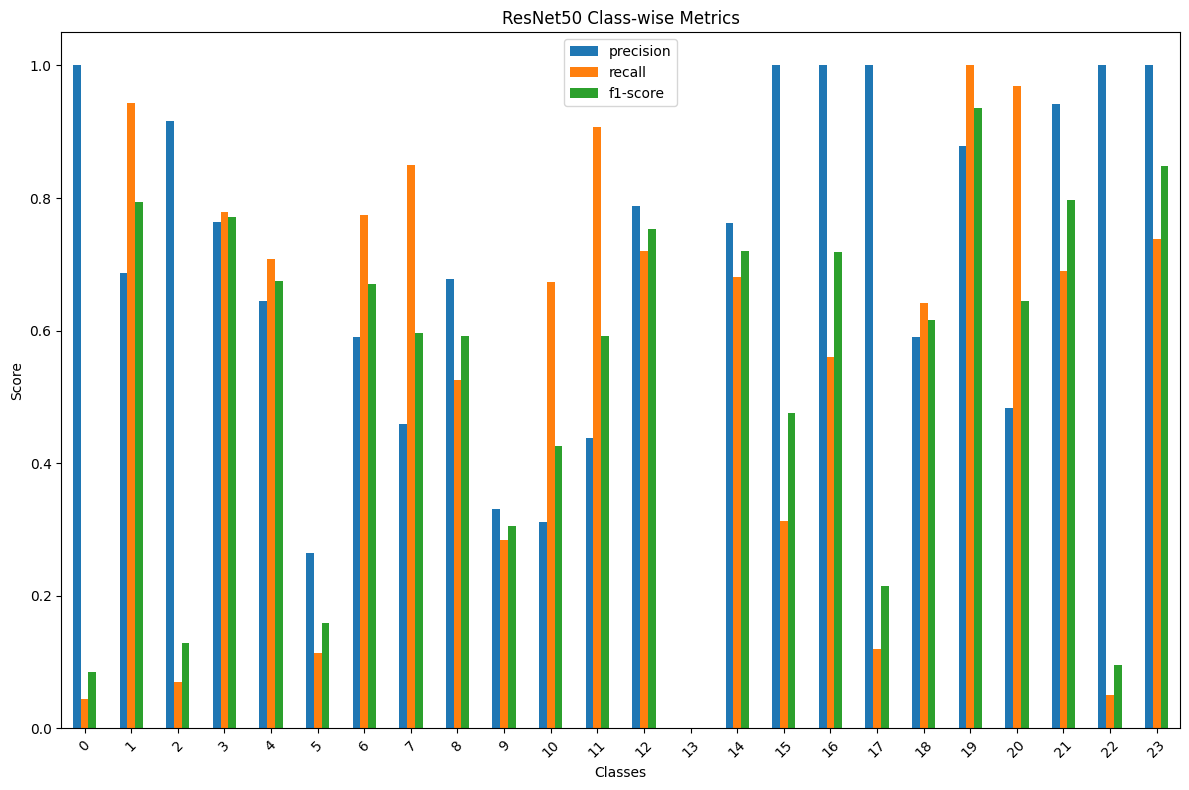

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pre-trained ResNet50 modelinin yüklenmesi
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Fine-tuning için katmanların ayarlanması
def freeze_base_model(base_model, unfreeze_from_layer=4):
    base_model.trainable = True
    for layer in base_model.layers[:-unfreeze_from_layer]:
        layer.trainable = False

freeze_base_model(resnet50_model, unfreeze_from_layer=4)

# Özel sınıflandırıcı başlığını ekleme
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(24, activation='softmax')(x)  # 24 sınıf
    model = Model(inputs=base_model.input, outputs=x)
    return model

# ResNet50 modelinin oluşturulması
resnet50_model_final = build_model(resnet50_model)

# Modelin derlenmesi
resnet50_model_final.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Veri artırma ve yeniden ölçeklendirme
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train ve validation generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # Ensure order consistency for validation
)

# Eğitim süreci
history_resnet50 = resnet50_model_final.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Tahminler ve değerlendirme
preds_resnet50 = np.argmax(resnet50_model_final.predict(validation_generator), axis=1)
accuracy_resnet50 = accuracy_score(validation_generator.classes, preds_resnet50)
recall_resnet50 = recall_score(validation_generator.classes, preds_resnet50, average='weighted')
f1_resnet50 = f1_score(validation_generator.classes, preds_resnet50, average='weighted')

# Sınıflandırma raporu
report_resnet50 = classification_report(validation_generator.classes, preds_resnet50, output_dict=True)
df_report_resnet50 = pd.DataFrame(report_resnet50).transpose()
df_report_resnet50.to_csv("ResNet50_classification_report_fine_tuning.csv")

# Performans sonuçlarını yazdır
results_resnet50 = {
    'Model': 'ResNet50',
    'Accuracy': accuracy_resnet50,
    'Recall': recall_resnet50,
    'F1-Score': f1_resnet50
}
print(pd.DataFrame([results_resnet50]))

# Performans görselleştirilmesi
df_report_resnet50.iloc[:-3, :3].plot(kind='bar', figsize=(12, 8))
plt.title('ResNet50 Class-wise Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
results_resnet50

{'Model': 'ResNet50',
 'Accuracy': 0.5674373795761078,
 'Recall': 0.5674373795761078,
 'F1-Score': 0.5154870379979453}

c:\Users\Baki Akgun\New Folder\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 100, 100, 3))',)
  warnings.warn(msg)


64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step


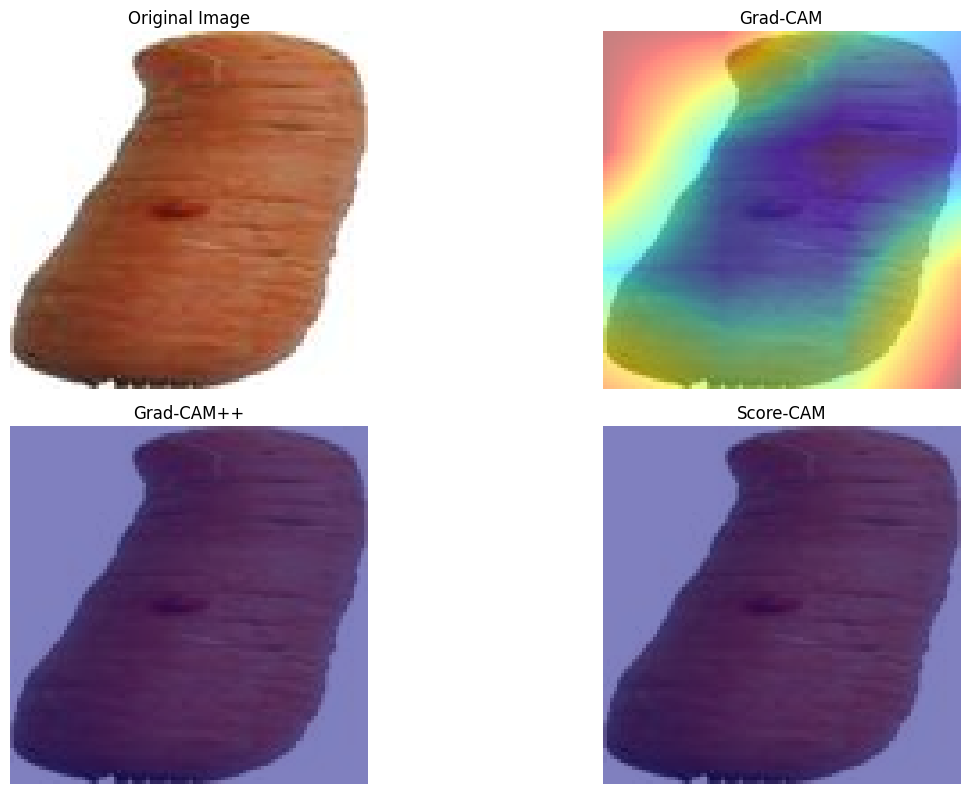

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step


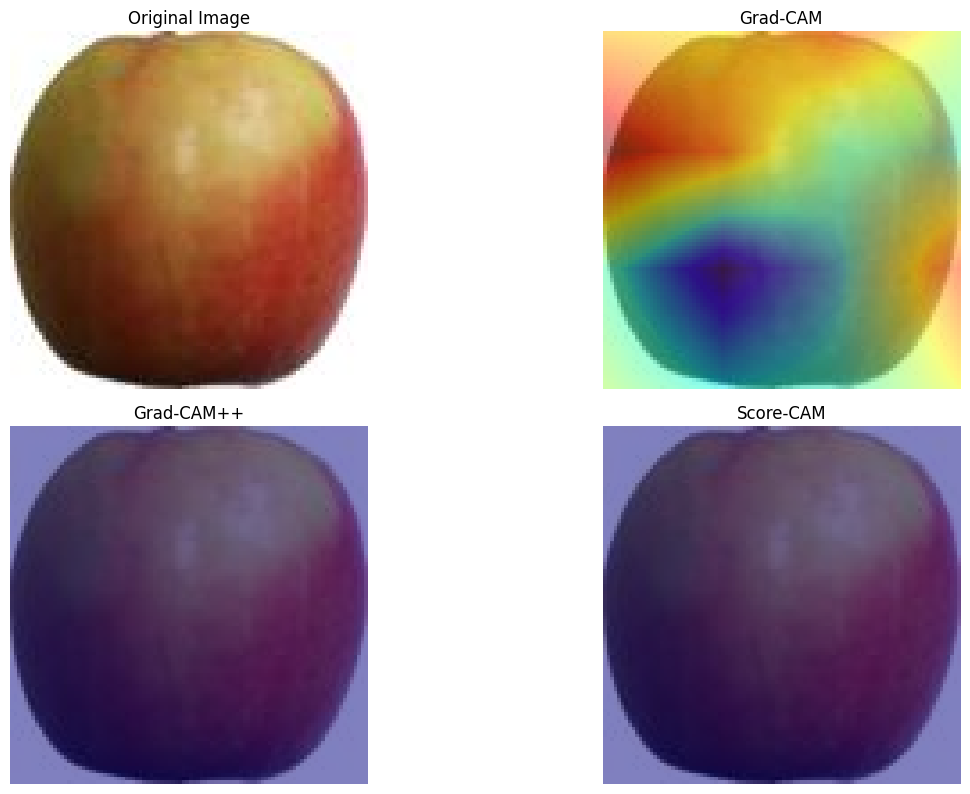

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam as GradcamClass
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.scorecam import ScoreCAM  # For Score-CAM

# Görüntüyü yüklemek ve ön işlemek için fonksiyon
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(100, 100))  # Modelin giriş boyutuna göre yeniden boyutlandırma
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizasyon
    return img, img_array

# Grad-CAM, Grad-CAM++, Score-CAM ve XGrad-CAM görselleştirmesi için fonksiyon
def cam_methods(model, image_path, class_idx):
    img, img_array = load_and_preprocess_image(image_path)

    # Grad-CAM
    grad_cam = GradcamClass(model)
    grad_cam_map = grad_cam(CategoricalScore(class_idx), img_array)

    # Grad-CAM++
    grad_cam_plus_plus = GradcamPlusPlus(model)
    grad_cam_plus_plus_map = grad_cam_plus_plus(CategoricalScore(class_idx), img_array)

    # Score-CAM
    score_cam = ScoreCAM(model)
    score_cam_map = score_cam(CategoricalScore(class_idx), img_array)


    # Sonuçları Görselleştirme
    plt.figure(figsize=(12, 12))

    # Orijinal Görüntü
    plt.subplot(3, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Grad-CAM
    plt.subplot(3, 2, 2)
    plt.imshow(img)
    plt.imshow(grad_cam_map[0], cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')

    # Grad-CAM++
    plt.subplot(3, 2, 3)
    plt.imshow(img)
    plt.imshow(grad_cam_plus_plus_map[0], cmap='jet', alpha=0.5)
    plt.title("Grad-CAM++")
    plt.axis('off')

    # Score-CAM
    plt.subplot(3, 2, 4)
    plt.imshow(img)
    plt.imshow(score_cam_map[0], cmap='jet', alpha=0.5)
    plt.title("Score-CAM")
    plt.axis('off')



    plt.tight_layout()
    plt.show()

# Modeli yükleme ve fonksiyonu çağırma
image_path = "C:/Users/Baki Akgun/OneDrive/Masaüstü/Fruit/fruits-360_dataset_100x100/Test/carrot_1/r0_19.jpg"
image_path1 = "C:/Users/Baki Akgun/OneDrive/Masaüstü/Fruit/fruits-360_dataset_100x100/Test/apple_pink_lady_1/r0_11.jpg"

class_idx = 0  # Hedef sınıfın indeksini modelinize uygun ayarlayın

# Fonksiyonu çağırma
cam_methods(resnet50_model_final, image_path, class_idx)
cam_methods(resnet50_model_final, image_path1, class_idx)
